In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('CC GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8949 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS            

As you can see there are two features with missing values. First we need to fix these issue. It seems the data are missing at random.

In [4]:
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean())
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8950 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS            

Now we will drop the first features since the customer id does not add any information to our model.

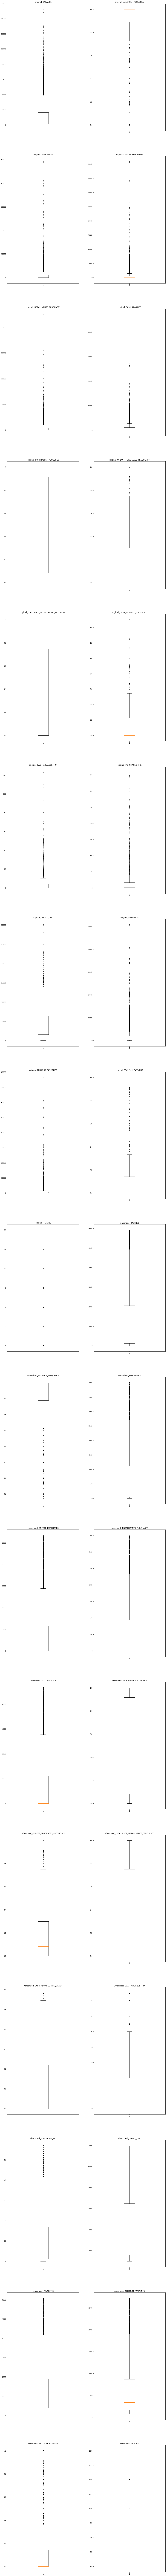

In [5]:
from scipy.stats.mstats import winsorize
plt.figure(figsize=(18,300))
columns = df.select_dtypes(['int64', 'float64']).columns
for index, value in enumerate(columns):
    
    plt.subplot(17,2,index+1)
    original = df[value]
    plt.boxplot(original)
    plt.title("original_" + value)

    plt.subplot(17,2,index+18)
    winsorized = winsorize(df[value],(.05,0.05))
    plt.boxplot(winsorized)
    plt.title("winsorized_" + value)

plt.show()



For unsupervised learning we usually do not care about outliers, however, since I lost one point on my previous unsupervised learning project for that I added it to this notebook!

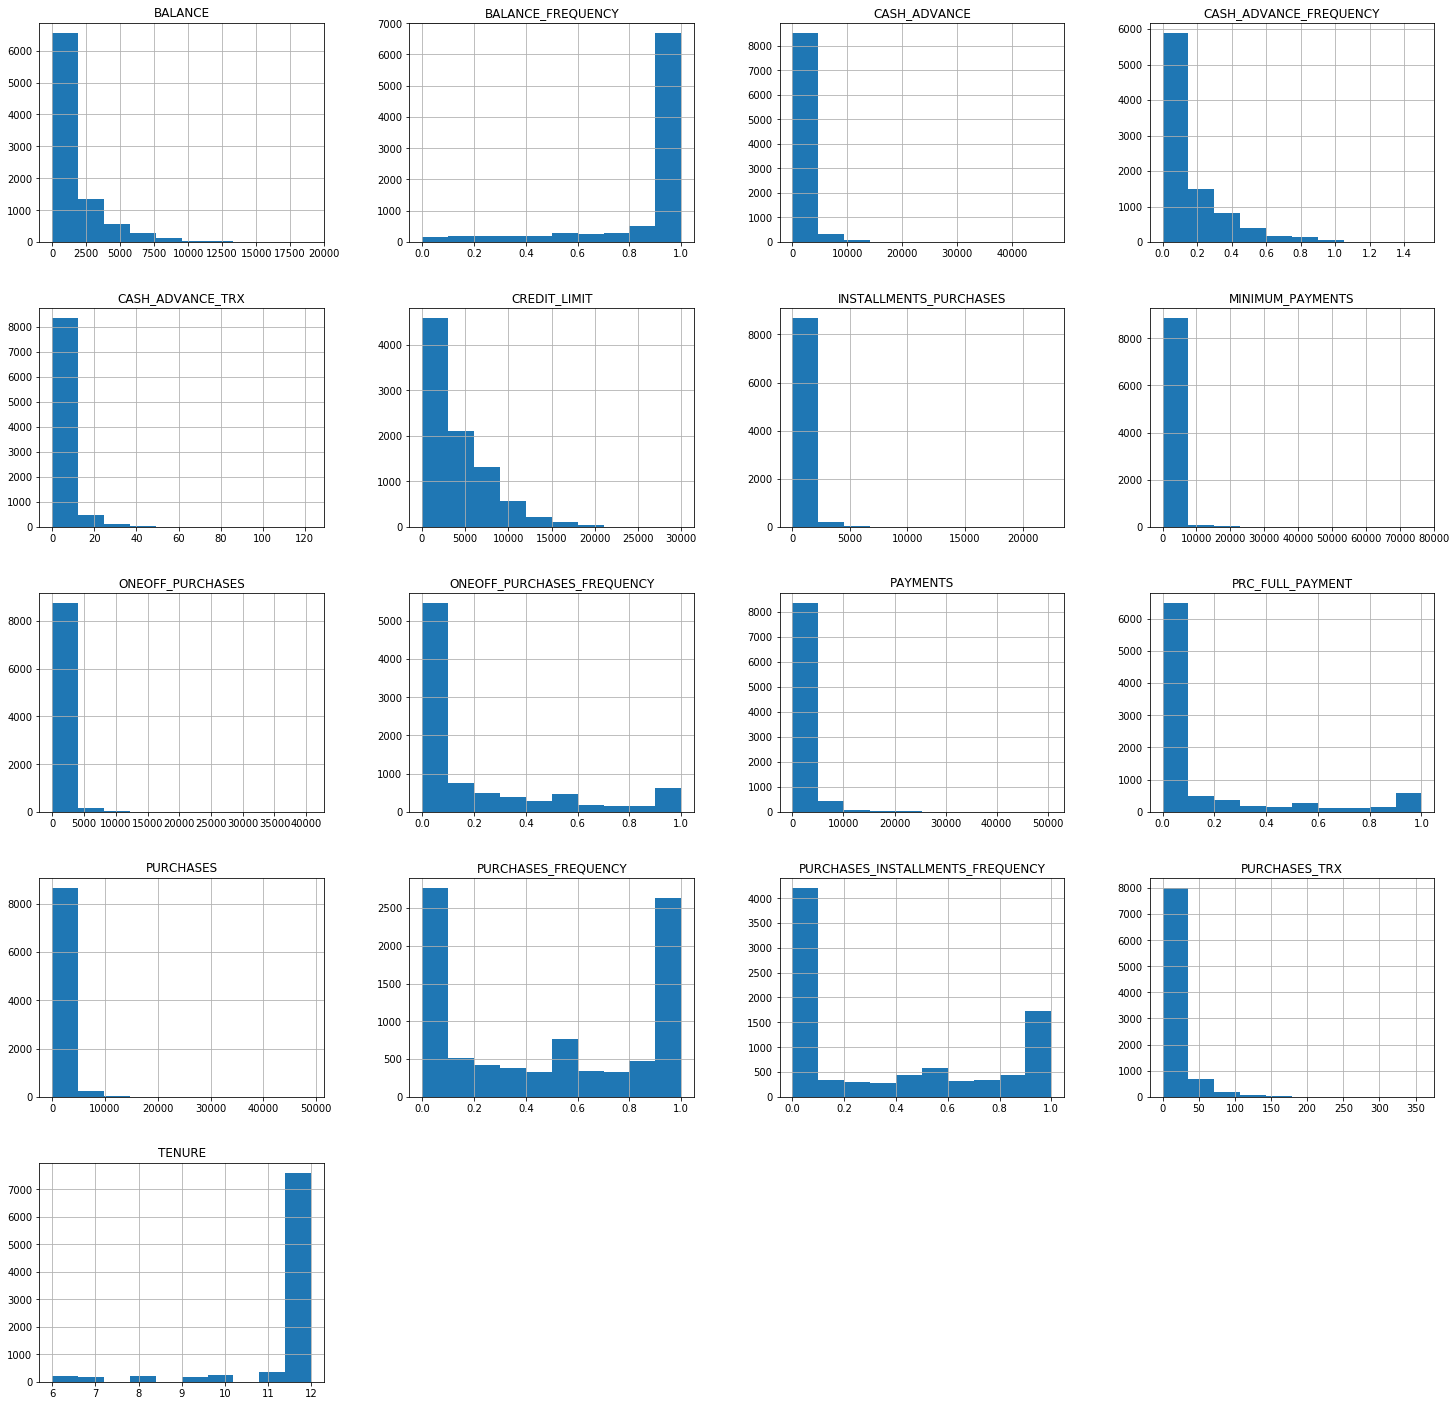

In [6]:
df.hist(figsize=(25,25))
plt.show()

In [7]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.612411,2895.063757,2330.588021,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,170.857654,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,335.628312,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,864.206542,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


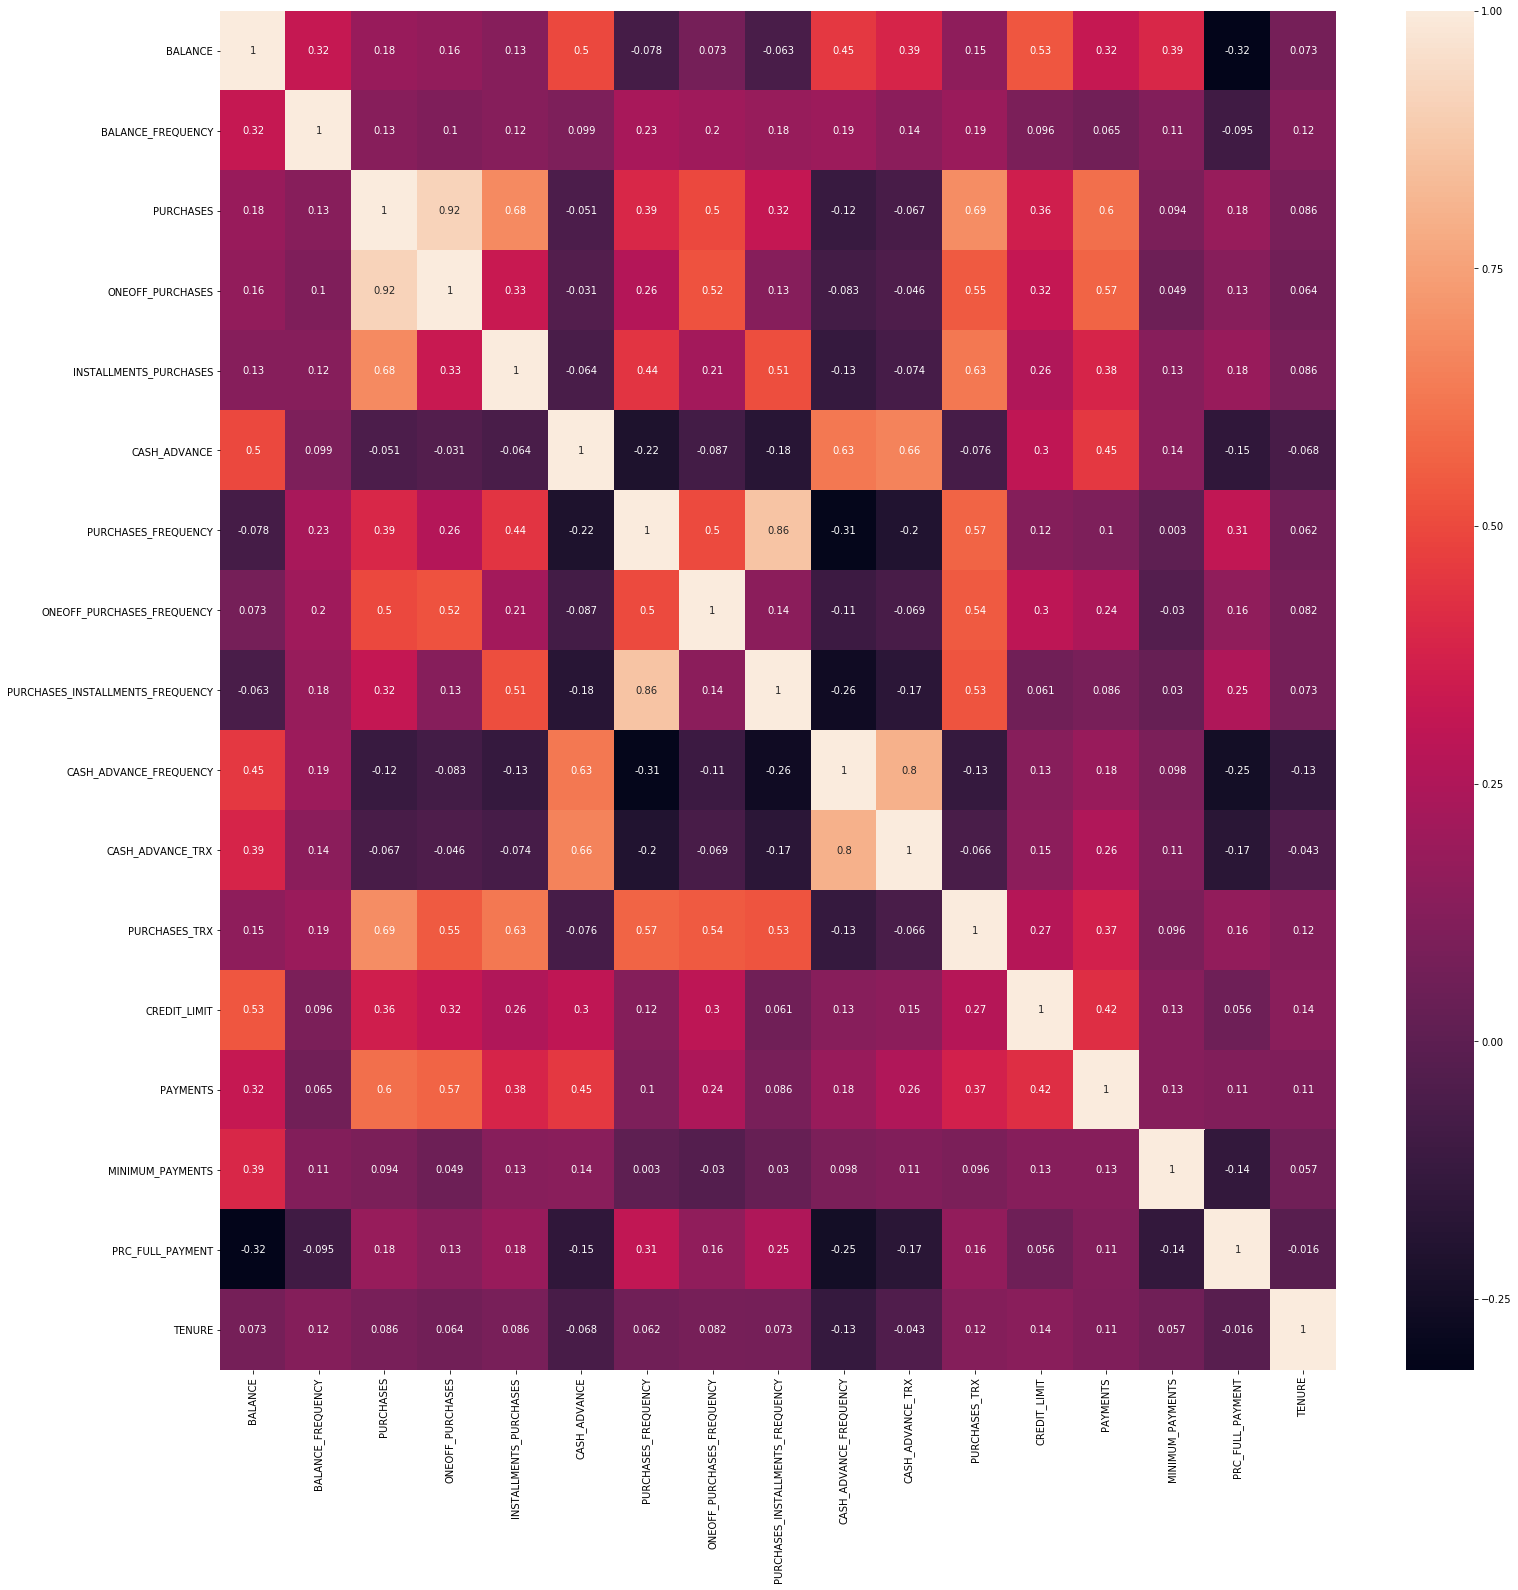

In [8]:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(),annot=True)
plt.show()

We can drop highly correlaited features such as onooff_purchases and installments_purchases

I will drop the curtomer ID since it does not add any information to our clustering model and then normalize the data to make them prepare for clustering.

In [9]:
X = df.drop('CUST_ID', axis = 1)

# Standardize the data.
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X) 
  
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
X_std = pd.DataFrame(normalized_df) 

In [10]:
# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# K-Means
## Elbow Method
In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. The same method can be used to choose the number of parameters in other data-driven models, such as the number of principal components to describe a data set.

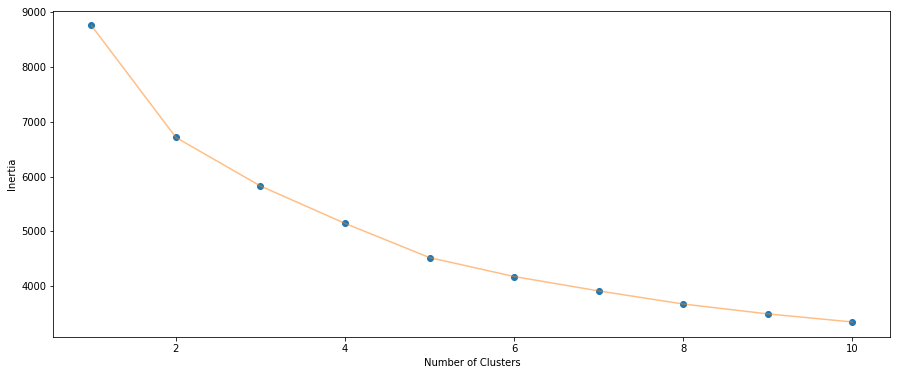

In [11]:
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X_std)
    inertia.append(algorithm.inertia_)
    
    
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

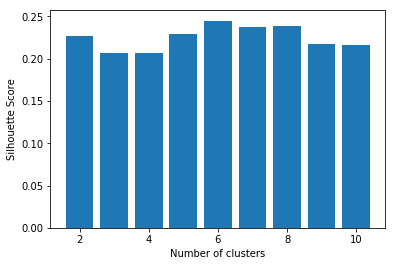

In [12]:
silhouette_scores = [] 

for n_cluster in range(2, 11):
    silhouette_scores.append( 
        metrics.silhouette_score(X_std, KMeans(n_clusters = n_cluster).fit_predict(X_std))) 
    
# Plotting a bar graph to compare the results 
k = range(2,11) 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

From both of the above visulizations 6 is the best number for the number of clusters.

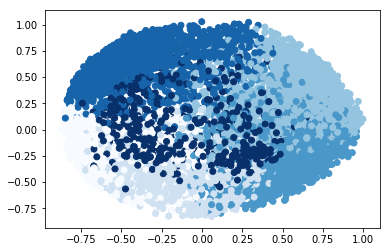

In [13]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_std)

# Visualizing the clustering 
plt.scatter(X_pca[:,0], X_pca[:,1],  
           c = KMeans(n_clusters = 6).fit_predict(X_std), cmap ='Blues') 
plt.show() 

In [14]:
labels=kmeans.labels_
clusters=pd.concat([X_std, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,cluster
0,-0.311938,-0.106297,-0.181072,-0.152108,-0.148760,-0.198921,-0.343687,-0.289212,-0.301422,-0.287801,-0.202878,-0.217905,-0.409290,-0.225425,-0.132519,-0.223964,0.153704,2
1,0.219925,0.037539,-0.131222,-0.099749,-0.127037,0.728166,-0.341434,-0.189660,-0.256265,0.160401,0.030761,-0.165384,0.192448,0.228779,0.024959,0.065457,0.100796,3
2,0.126682,0.146783,-0.030504,0.030850,-0.128790,-0.132249,0.359771,0.757440,-0.259802,-0.191339,-0.134880,-0.030888,0.234039,-0.108739,-0.028803,-0.148899,0.102187,4
3,0.020589,-0.426439,0.097309,0.229034,-0.190618,-0.154587,-0.425253,-0.167447,-0.384524,-0.108570,-0.138184,-0.231288,0.346393,-0.251048,0.000000,-0.220379,0.151244,1
4,-0.151595,0.218909,-0.195238,-0.146744,-0.192075,-0.197234,-0.428504,-0.168727,-0.387463,-0.285359,-0.201157,-0.233056,-0.382591,-0.153959,-0.112306,-0.222064,0.152400,2


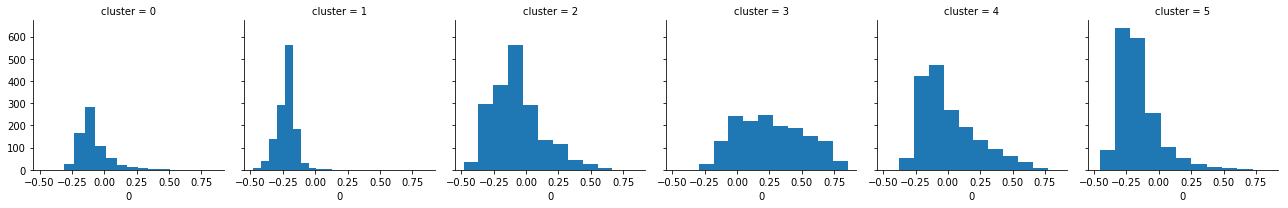

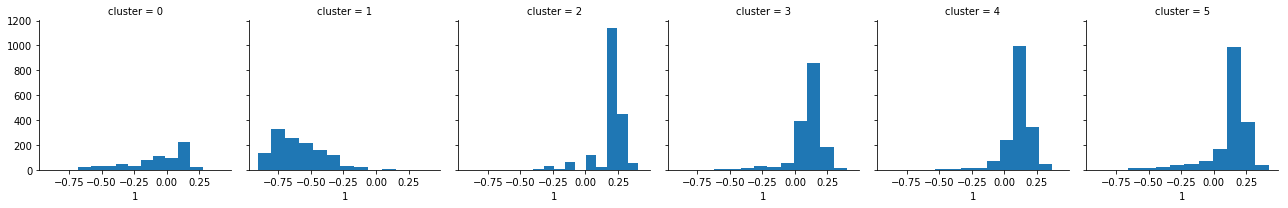

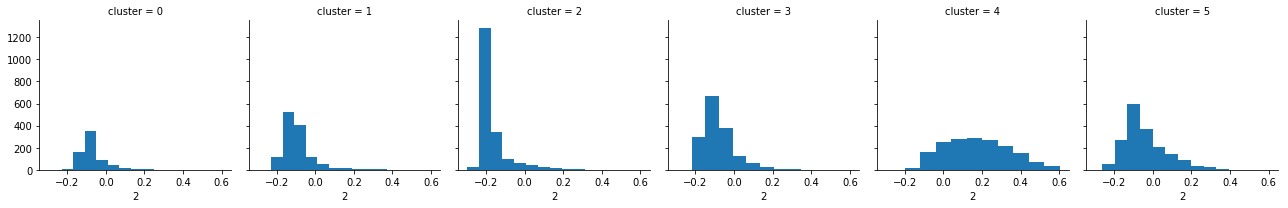

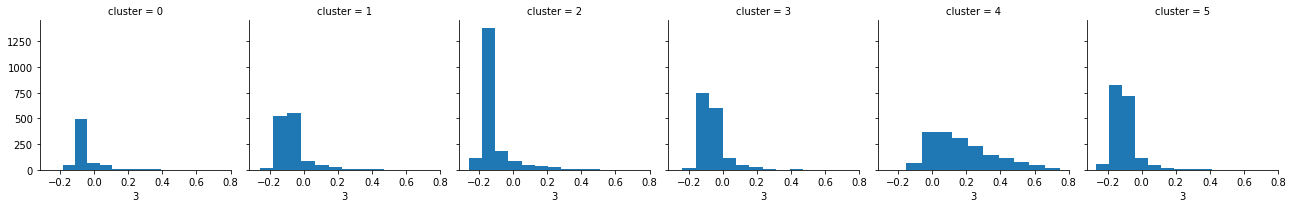

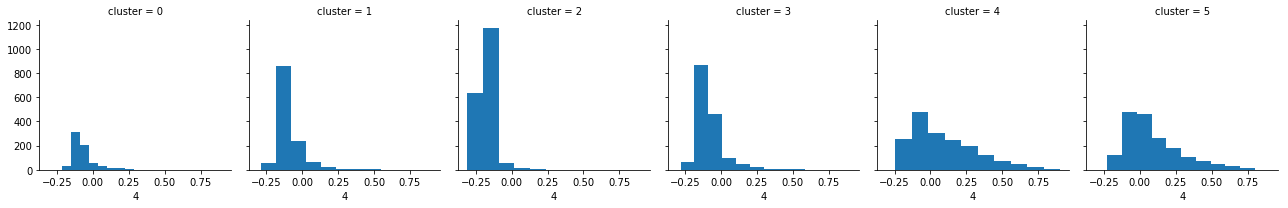

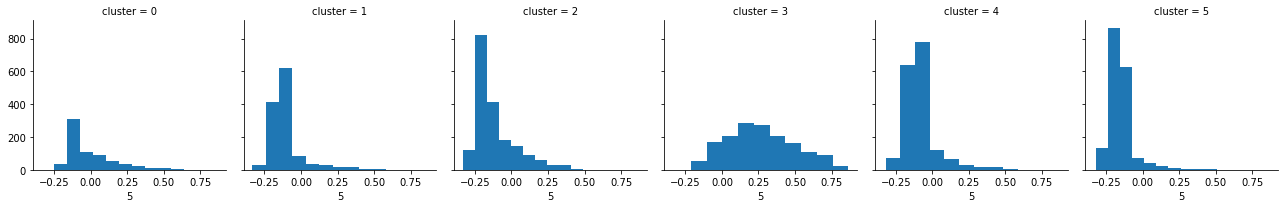

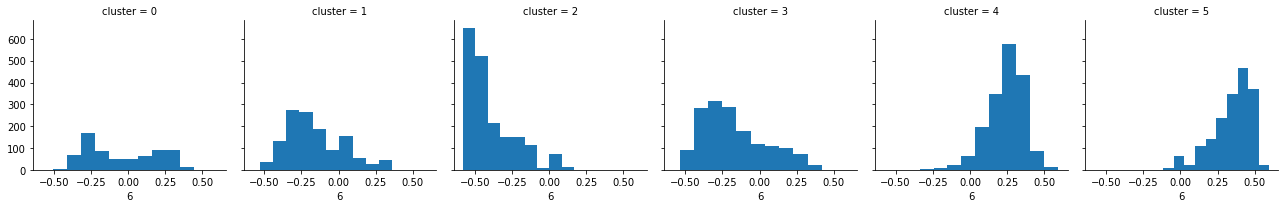

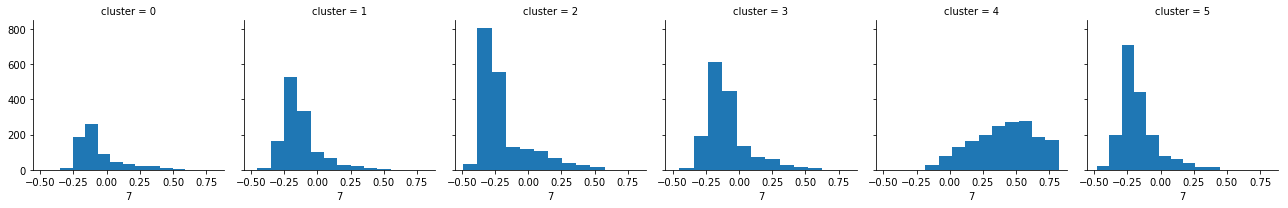

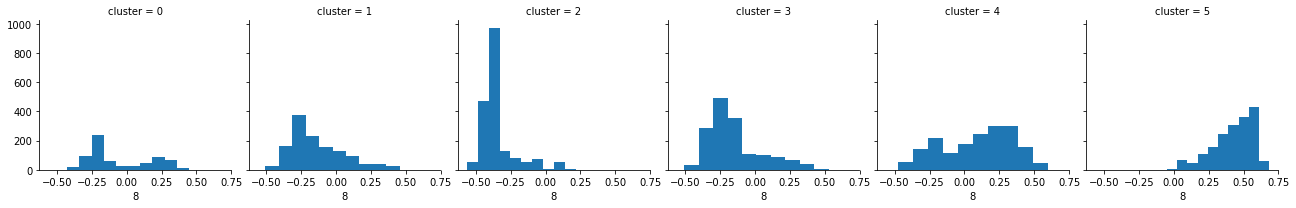

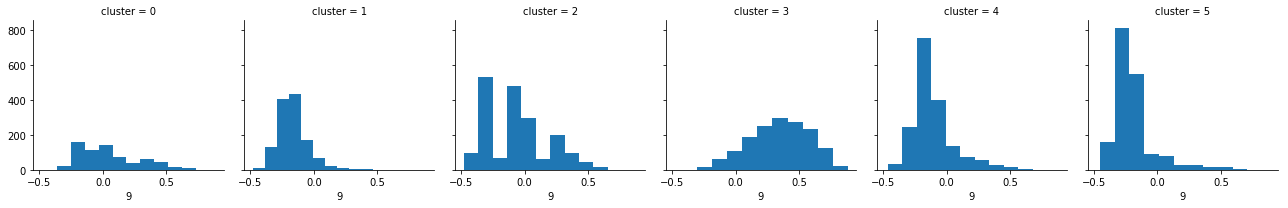

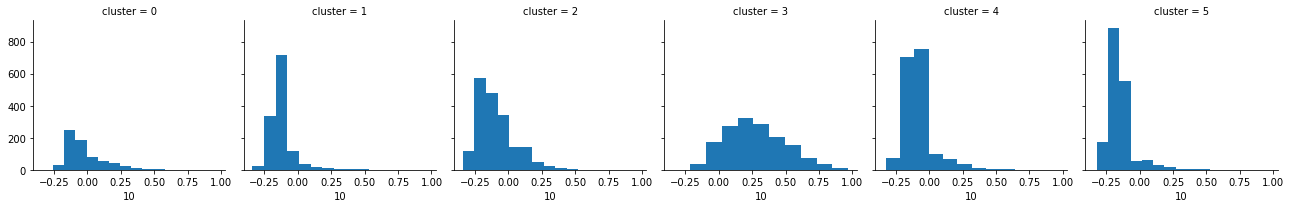

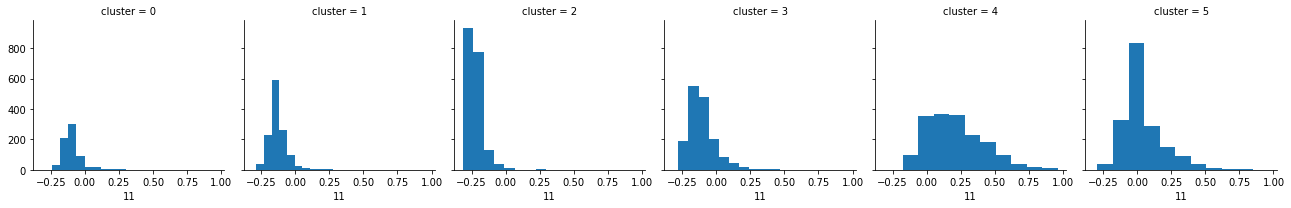

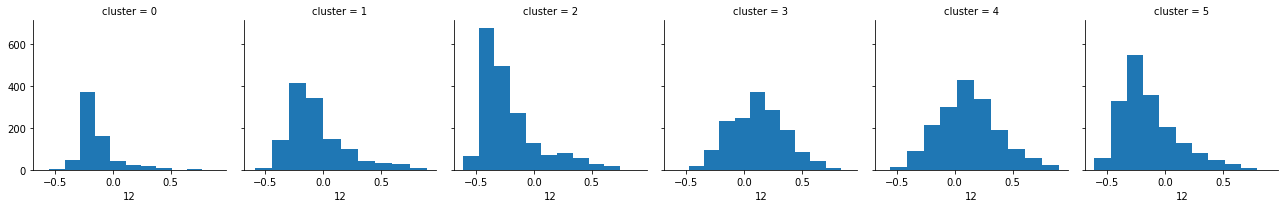

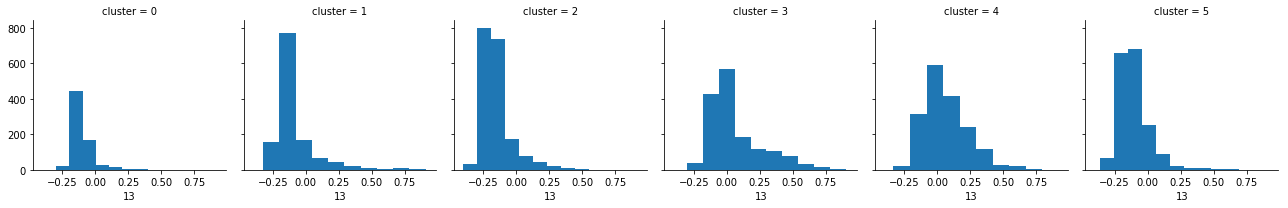

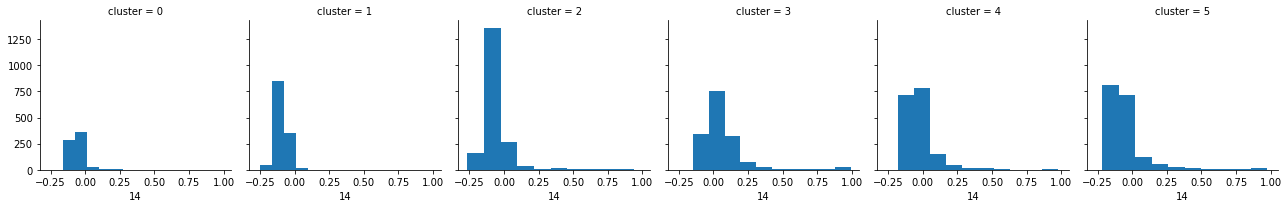

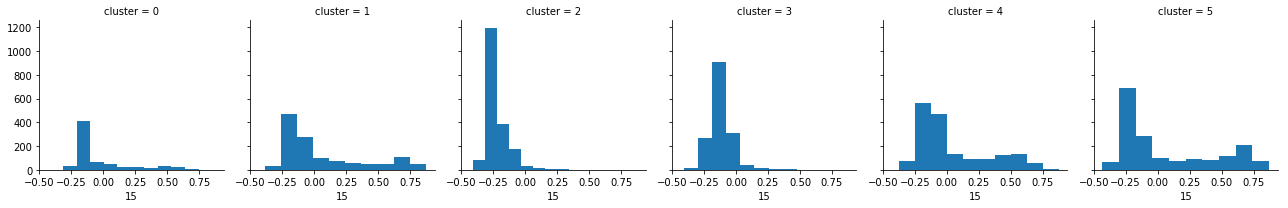

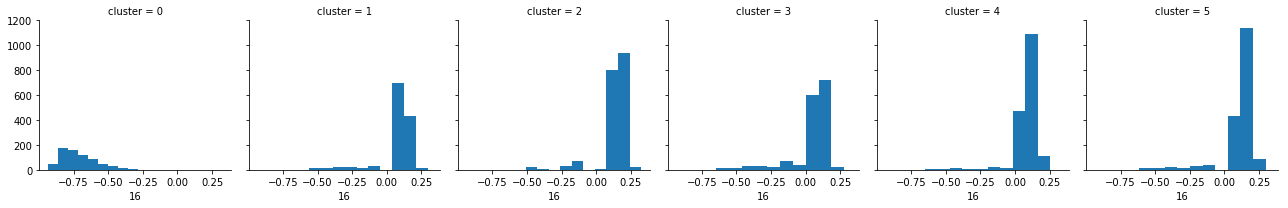

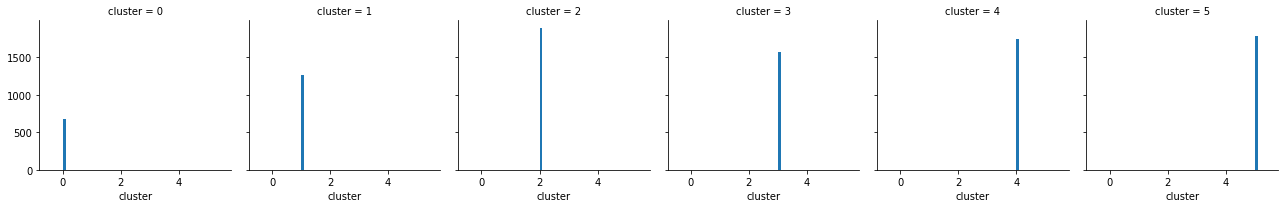

In [15]:
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

In [16]:
clusters.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
cluster,,,,,,,,,,,,,,,,,
0,-0.089960,-0.071361,-0.068129,-0.049032,-0.070847,-0.004313,-0.045337,-0.064985,-0.056004,0.043285,-0.016851,-0.093608,-0.142105,-0.097813,-0.053358,-0.015436,-0.710322
1,-0.222885,-0.597976,-0.095672,-0.073461,-0.091222,-0.108588,-0.163724,-0.133665,-0.133470,-0.170611,-0.124762,-0.130472,-0.061795,-0.081270,-0.085515,0.066143,0.081828
2,-0.071393,0.201597,-0.167084,-0.114044,-0.185470,-0.116275,-0.393701,-0.182210,-0.349123,-0.065080,-0.095137,-0.223122,-0.214325,-0.151565,-0.057104,-0.214499,0.138112
3,0.263919,0.108371,-0.081844,-0.059831,-0.083626,0.266538,-0.172222,-0.090199,-0.149510,0.345985,0.271641,-0.103758,0.118909,0.064991,0.067018,-0.115297,0.049438
4,0.009763,0.111471,0.174661,0.175283,0.090902,-0.083811,0.242805,0.408098,0.092337,-0.105026,-0.083160,0.208548,0.119581,0.061764,-0.018179,0.043722,0.080183
5,-0.157700,0.134597,-0.042389,-0.104329,0.091427,-0.149233,0.346459,-0.167749,0.425771,-0.192220,-0.145292,0.035883,-0.141765,-0.105734,-0.043086,0.071587,0.108083


1. Cluster0 People with average to high credit limit who make all type of purchases

2. Cluster1 This group has more people with due payments who take advance cash more often

3. Cluster2 Less money spenders with average to high credit limits who purchases mostly in installments

4. Cluster3 People with high credit limit who take more cash in advance

5. Cluster4 High spenders with high credit limit who make expensive purchases

6. Cluster5 People who don't spend much money and who have average to high credit limit

(Clsuter number changes when re run)

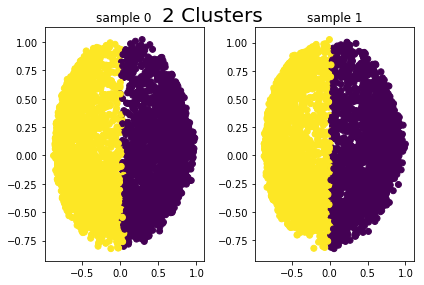

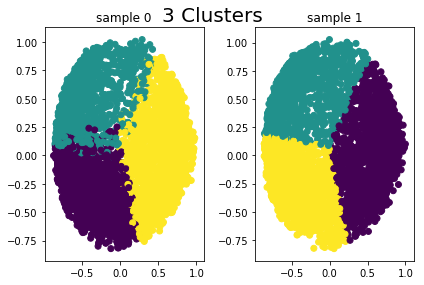

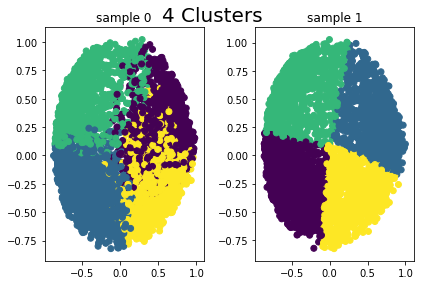

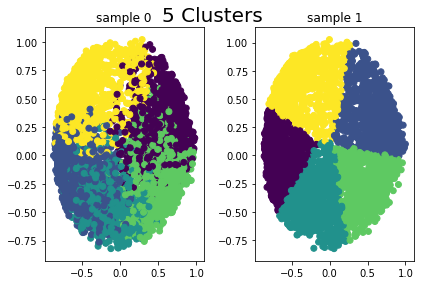

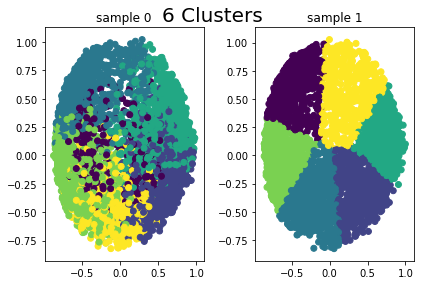

In [17]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

from sklearn.model_selection import train_test_split
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=123)


# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    for nclust in range(2, 7):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 7):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()    

In [18]:
for nclust in range(2, 7):
    pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(X_std)
    print('Silhouette score for ' + str(nclust) + ' cluster k-means: {}'.format(
    metrics.silhouette_score(X_std, pred, metric='euclidean')))

Silhouette score for 2 cluster k-means: 0.22723866707977472
Silhouette score for 3 cluster k-means: 0.20661457845561704
Silhouette score for 4 cluster k-means: 0.20664457298690242
Silhouette score for 5 cluster k-means: 0.2292240906339161
Silhouette score for 6 cluster k-means: 0.24497835095440687


As you can compare the silhoutte score and above graphs, six clusters has the highest score. However, choosing the right number of cluster deponds on the goal of clustering and decision that will be made. For example, if we are looking to give a person a new credit card or not we can go by clustering by 2. Therefore, I think 3 for this project is the best to compare different unsupervising models, graphs and diminsion reduction techniques.

Using PCA, t-sne and Umap to transform data to 2 dimensions for visualization and compare their results.

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8950 samples in 0.007s...
[t-SNE] Computed neighbors for 8950 samples in 2.002s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8950
[t-SNE] Computed conditional probabilities for sample 2000 / 8950
[t-SNE] Computed conditional probabilities for sample 3000 / 8950
[t-SNE] Computed conditional probabilities for sample 4000 / 8950
[t-SNE] Computed conditional probabilities for sample 5000 / 8950
[t-SNE] Computed conditional probabilities for sample 6000 / 8950
[t-SNE] Computed conditional probabilities for sample 7000 / 8950
[t-SNE] Computed conditional probabilities for sample 8000 / 8950
[t-SNE] Computed conditional probabilities for sample 8950 / 8950
[t-SNE] Mean sigma: 0.161905
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.988815
[t-SNE] KL divergence after 300 iterations: 2.479615


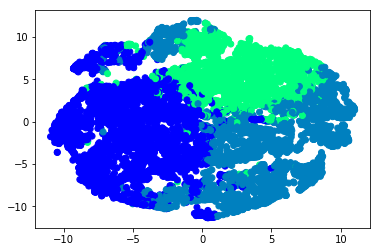

In [20]:
# Now try the kmeans with t-sne 

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_std)

# Visualizing the clustering 
plt.scatter(X_tsne[:,0], X_tsne[:,1],  
           c = KMeans(n_clusters = 3).fit_predict(X_std), cmap =plt.cm.winter) 
plt.show()

In [21]:
!pip install umap-learn
import umap

X_umap = umap.UMAP(n_neighbors=3,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


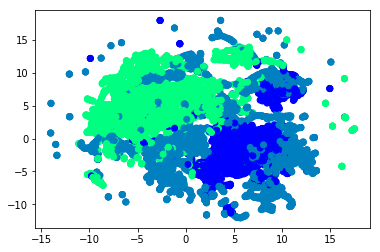

In [22]:
# Now try the kmeans with UMAP 

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_std)

# Visualizing the clustering 
plt.scatter(X_umap[:,0], X_umap[:,1],  
           c = KMeans(n_clusters = 3).fit_predict(X_std), cmap =plt.cm.winter) 
plt.show()

## Agglomerative Clustering

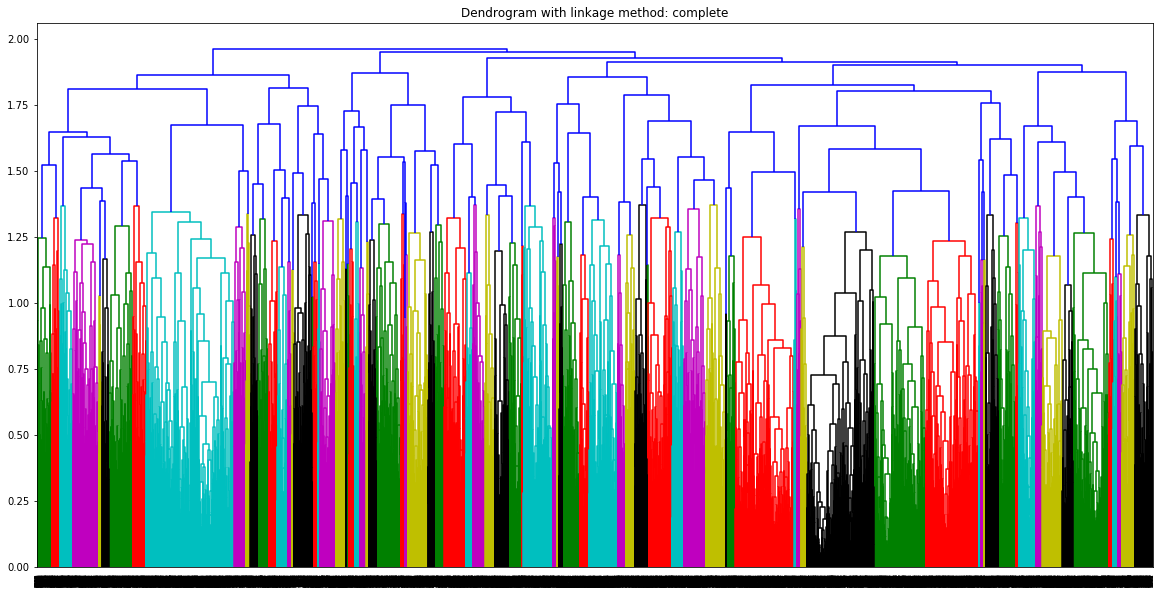

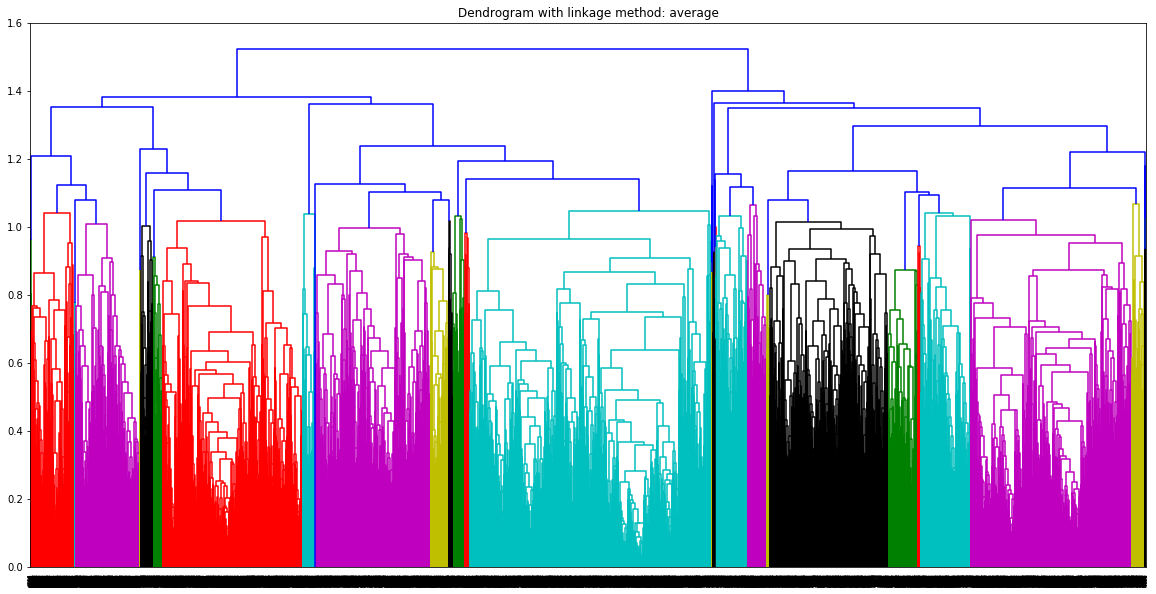

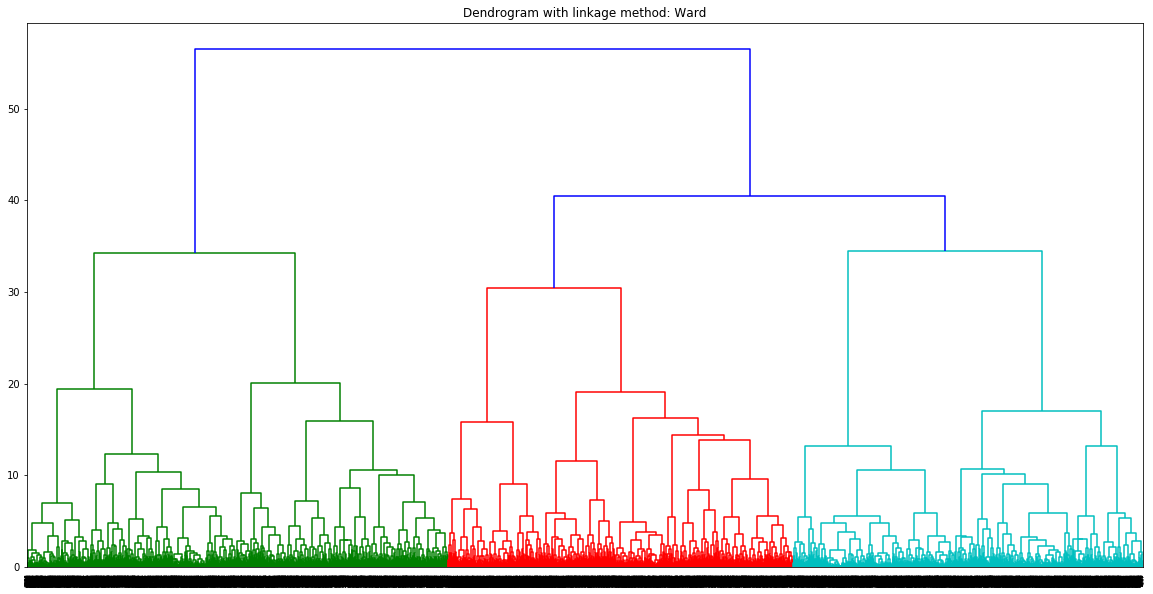

In [23]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: complete")
dendrogram(linkage(X_std, method='complete'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: average")
dendrogram(linkage(X_std, method='average'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: Ward")
dendrogram(linkage(X_std, method='ward'))
plt.show()

In [24]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=3)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

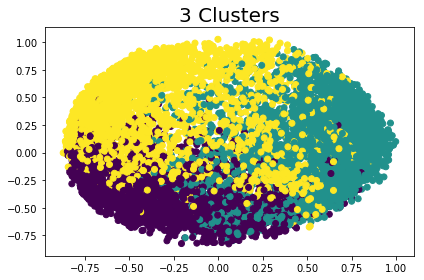

In [25]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
        
plt.title('3 Clusters', fontsize=20) 
plt.tight_layout()
plt.show()

The more reasonable result is that of the ward method's. The complete and average methods produced results that are hard to reconcile with the facts as their two cluster solutions has too few observations for one of the clusters.

In [26]:
print("The silhoutte score of the Agglomerative Clustering solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

The silhoutte score of the Agglomerative Clustering solution: 0.16269232126810304


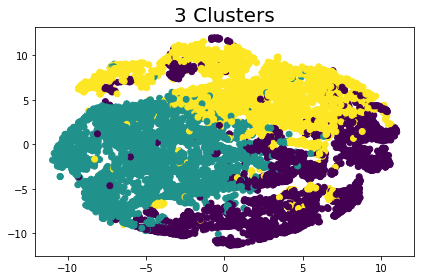

In [27]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters)
        
plt.title('3 Clusters', fontsize=20) 
plt.tight_layout()
plt.show()

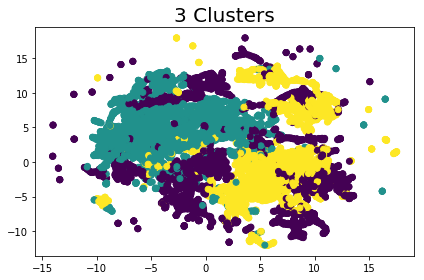

In [28]:
plt.scatter(X_umap[:,0], X_umap[:,1], c=clusters)
        
plt.title('3 Clusters', fontsize=20) 
plt.tight_layout()
plt.show()

The pca has better clustering in compare with t-sne and umap.

## DBSCAN clustering

In [29]:
# Defining the DBSCAN clustering
dbscan_cluster = DBSCAN(eps=.4, min_samples=5)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

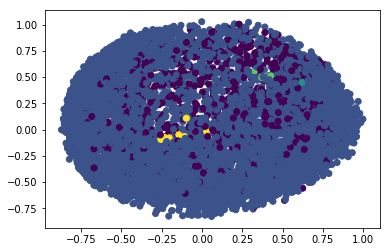

In [30]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
plt.show()

In [31]:
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

The silhouette score of the DBSCAN solution: -0.12449882105324804


In [32]:
print("Number of clusters when min_samples=1 is: {}".format(len(np.unique(clusters))))

min_samples_list = range(2,11)

for i in range(2,11):
    dbscan_cluster = DBSCAN(eps=.8, min_samples=i, metric="euclidean")
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    print("Number of clusters when min_samples={} is: {}".format(i, len(np.unique(clusters))))

Number of clusters when min_samples=1 is: 5
Number of clusters when min_samples=2 is: 1
Number of clusters when min_samples=3 is: 1
Number of clusters when min_samples=4 is: 1
Number of clusters when min_samples=5 is: 1
Number of clusters when min_samples=6 is: 1
Number of clusters when min_samples=7 is: 1
Number of clusters when min_samples=8 is: 1
Number of clusters when min_samples=9 is: 1
Number of clusters when min_samples=10 is: 1


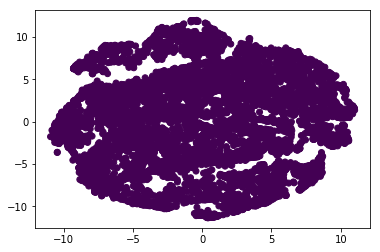

In [33]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters)
plt.show()

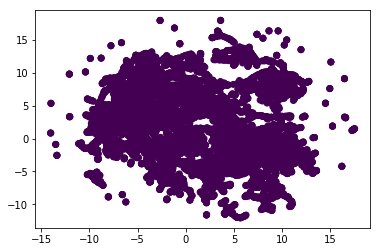

In [34]:
plt.scatter(X_umap[:,0], X_umap[:,1], c=clusters)
plt.show()

In [35]:
print("Number of clusters when min_samples=1 is: {}".format(len(np.unique(clusters))))

min_samples_list = range(2,11)

for i in range(2,11):
    dbscan_cluster = DBSCAN(eps=.4, min_samples=i, metric="euclidean")
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    print("Number of clusters when min_samples={} is: {}".format(i, len(np.unique(clusters))))

Number of clusters when min_samples=1 is: 1
Number of clusters when min_samples=2 is: 59
Number of clusters when min_samples=3 is: 15
Number of clusters when min_samples=4 is: 5
Number of clusters when min_samples=5 is: 5
Number of clusters when min_samples=6 is: 3
Number of clusters when min_samples=7 is: 2
Number of clusters when min_samples=8 is: 2
Number of clusters when min_samples=9 is: 2
Number of clusters when min_samples=10 is: 2


## Gaussian Mixture

In [36]:
from sklearn.mixture import GaussianMixture

# Defining the Gaussian Mixture Models clustering
gmm_cluster = GaussianMixture(n_components=3, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

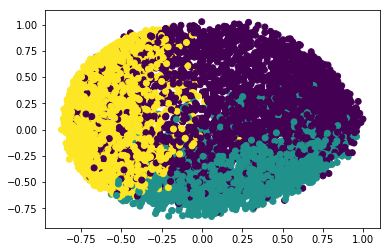

In [37]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
plt.show()

In [38]:
for nclust in range(2,7):
    gmm_cluster = GaussianMixture(n_components=nclust, random_state=123)
    clusters = gmm_cluster.fit_predict(X_std)
    print("The silhouette score of the Gaussian Mixture Models solution with {} clusters: {}"
          .format(nclust, metrics.silhouette_score(X_std, clusters, metric='euclidean')))

The silhouette score of the Gaussian Mixture Models solution with 2 clusters: 0.15747188665246864
The silhouette score of the Gaussian Mixture Models solution with 3 clusters: 0.13264994436414915
The silhouette score of the Gaussian Mixture Models solution with 4 clusters: 0.06901514506380999
The silhouette score of the Gaussian Mixture Models solution with 5 clusters: 0.06728078956973269
The silhouette score of the Gaussian Mixture Models solution with 6 clusters: 0.049152063985804476


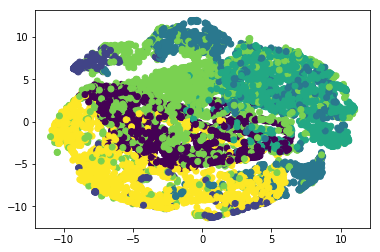

In [39]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters)
plt.show()

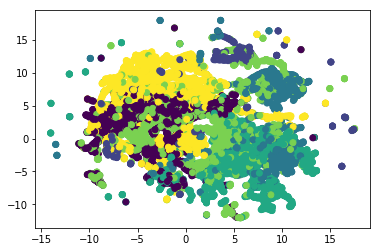

In [40]:
plt.scatter(X_umap[:,0], X_umap[:,1], c=clusters)
plt.show()

Comparin the graphs and different techniques shows PCA has better visualizations since the dataset is really dense. Addtionally, DBSCAN does not have a good result in clustering due to same issue of high density in dataset.

## Spectral Clustering

In [41]:
Xhalf1, Xhalf2, X_pca_1, X_pca_2 = train_test_split(X_std, X_pca, test_size=0.5, random_state=85)
Xhalf2 = Xhalf2[:4474][:]
Xhalf1 = Xhalf1[:4474][:]
X_pca_1 = X_pca_1[:4474][:]
X_pca_2 = X_pca_2[:4474][:]

In [42]:
# Initialize data frames
ypred_sc = pd.DataFrame()
score_sc = pd.DataFrame(columns=['cluster_pred','silhouette_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (Xhalf1, X_pca_1),
    (Xhalf2, X_pca_2)]):
    
    # Put the features into ypred.
    ypred_sc['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_sc['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
        # Instantiating and fit_predicting model to then add to data frame
        sc = SpectralClustering(n_clusters=nclust)
        pred = sc.fit_predict(data[0])
        ypred_sc['clust' + str(nclust) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = sc.labels_
        sscore_sc = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score_sc = score_sc.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'silhouette_score':sscore_sc}, ignore_index=True)

In [43]:
score_sc.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,silhouette_score
0,clust2_sample0,0.230599
3,clust5_sample0,0.228253
7,clust5_sample1,0.226783
4,clust2_sample1,0.223344
6,clust4_sample1,0.211777
2,clust4_sample0,0.210419
5,clust3_sample1,0.206454
1,clust3_sample0,0.203958


By Comparing all the above visualizations and silhouette score we can see K-Means with 3 not only has one the most clean and consistent visualization but also has one of the highest silhouette score. Clustering in unsupervised learning without any labels is really ambigious task. The goal of clustering is to determine the internal grouping in a set of unlabeled data. But how to decide what constitutes a good clustering? It can be shown that there is no absolute “best” criterion which would be independent of the final aim of the clustering. Consequently, it is the user who should supply this criterion, in such a way that the result of the clustering will suit their needs.

This last problem is particularly troublesome, since we often have no way of knowing how many clusters exist. In the example shown above, the same algorithm applied to the same data produces the following 3-means clustering. Is it better or worse than the 2-means clustering?
Unfortunately there is no general theoretical solution to find the optimal number of clusters for any given data set. A simple approach is to compare the results of multiple runs with different k classes and choose the best one according to a given criterion, but we need to be careful because increasing k results in smaller error function values by definition, but also increases the risk of overfitting.

Finally, based on the goal of project and the results the method and number of clusters can be chosen. For example, if the goal is to accept someone's new credit card application or not, the k can be equal to 2. Or we can cluster credit card users in three groups base on their usage of their cards into high, medium and less purchases made.